In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [2]:
books = pd.read_csv('books.csv')

In [3]:
books.sample(3)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
2556,9780425136980,0425136981,Shadow Fires,NaN,Dean Ray Koontz,Fiction,http://books.google.com/books/content?id=7XO7F...,After her husband's mangled corpse disappears ...,1987.0,3.78,528.0,9527.0
3395,9780552998819,0552998818,Sure of You,NaN,Armistead Maupin,City and town life,http://books.google.com/books/content?id=oFsQQ...,____________________ Soon to be a Netflix seri...,1991.0,4.03,284.0,5370.0
2444,9780393963045,0393963047,"The Foundations of Early Modern Europe, 1460-1559",NaN,Eugene F. Rice;Anthony Grafton,History,http://books.google.com/books/content?id=W_-kQ...,This synthesis of Europe's Renaissance and Ref...,1994.0,3.67,218.0,169.0


## Inspecting Missing Data

<Axes: >

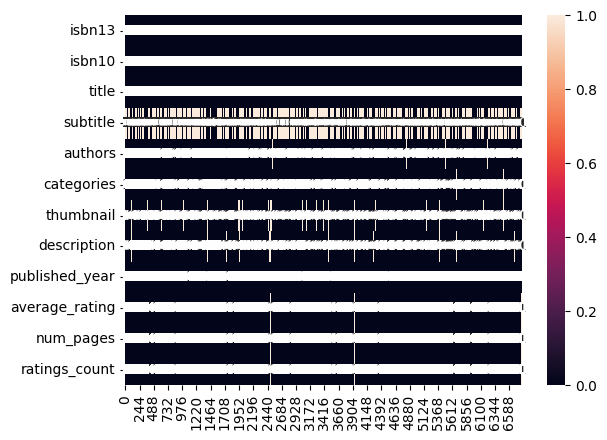

In [4]:
ax = plt.axes()
sns.heatmap(books.isna().T,annot=True,ax = ax)

In [5]:
books['missing_descr'] = np.where(books['description'].isna(),1,0)
books['old_wrt2025'] = 2025 - books['published_year']

<Axes: >

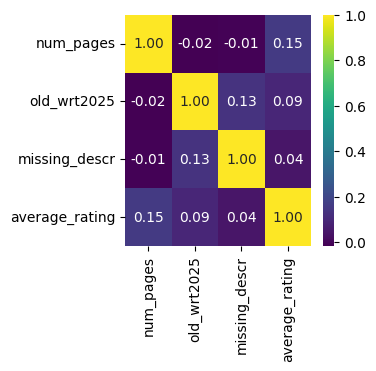

In [6]:
columns_considered = ['num_pages','old_wrt2025','missing_descr','average_rating']

corr_df = books[columns_considered].corr(method='spearman')
plt.figure(figsize=(3,3))
sns.heatmap(corr_df,annot = True,fmt = ".2f",cmap = 'viridis')

Observation: Missing description doesn't have correlation with old_wrt2025, or average rating or num_pages.  
So we can drop books wo description without any bias creeping in.

In [7]:
# dropping books with any of description, num-pages, average rating and published year
books = books.dropna(subset=['description','num_pages','average_rating','published_year'],how = 'any',axis = 0)

## Unique categories of Books

In [8]:
books['categories'].value_counts().sort_values(ascending=False)

categories
Fiction                      2523
Juvenile Fiction              534
Biography & Autobiography     391
History                       258
Literary Criticism            164
                             ... 
Butlers                         1
Gardens                         1
Assassins                       1
Married people                  1
Indic fiction (English)         1
Name: count, Length: 531, dtype: int64

In [9]:
books['categories'].nunique()

531

We need to reduce the categories into reasonable number of buckets using LLM

## Book Description

In [10]:
books['descr_length'] = books['description'].str.split().str.len()

In [11]:
percentiles = [1,5,25,50,75,95,99]
percentile_values = books['descr_length'].quantile([p/100 for p in percentiles]).to_dict()
percentile_values

{0.01: 5.060000000000002,
 0.05: 14.0,
 0.25: 27.0,
 0.5: 40.0,
 0.75: 82.0,
 0.95: 200.69999999999982,
 0.99: 307.9399999999996}

In [12]:
small_descr = books[books['descr_length'].between(14,15)]['description']
small_descr

2       Volume Two of Stephen Donaldson's acclaimed se...
83      Tie your tongue in terrible knots as you try t...
90      An epic narrative that takes a look at slavery...
94      The title story in this collection of shorts n...
111     Rabbit's schedule keeps him so busy his friend...
                              ...                        
6644    Twenty-one stories include "The Turn of the Sc...
6655    "How truth commissions around the world are ch...
6681    Presents a collection of short stories, includ...
6730    Nineteen writers dig into the spaces between g...
6767    Everything from the fingerprints of the gods t...
Name: description, Length: 158, dtype: object

In [13]:
books = books[books['descr_length']>=15]

In [14]:
books.shape

(6144, 15)

## Pairing title and subtitle into single field

In [16]:
print(books['title'].isna().sum())
print(books['subtitle'].isna().sum())


0
3989


In [21]:
# if subtitle doesn't exist keep it as title, else using agg over string keep title: subtitle
books['title_subtitle'] = np.where(books['subtitle'].isna(),books['title'],
                                   books[['title','subtitle']].astype(str).agg(": ".join,axis = 1))

In [22]:
books['title_subtitle']

0                                                  Gilead
1                                   Spider's Web: A Novel
3                                          Rage of angels
4                                          The Four Loves
5                                     The Problem of Pain
                              ...                        
6803                                  Journey to the East
6804    The Monk Who Sold His Ferrari: A Fable About F...
6805       I Am that: Talks with Sri Nisargadatta Maharaj
6808                             The Berlin Phenomenology
6809    'I'm Telling You Stories': Jeanette Winterson ...
Name: title_subtitle, Length: 6144, dtype: object

## Pairing isbn to description

In [23]:
books['tagged_descr'] = books[['isbn13','description']].astype(str).agg(": ".join,axis=1)

## Dropping irrelevant columns and saving cleaned dataset

In [24]:
books.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count', 'missing_descr', 'old_wrt2025',
       'descr_length', 'title_subtitle', 'tagged_descr'],
      dtype='object')

In [26]:
books.drop(columns=['subtitle','missing_descr','old_wrt2025','descr_length'],inplace=True)
books.to_csv('books_cleaned.csv',index=False)